# Segmentation of Customers of an Online store using Clustering

## 1. Reading & Understanding the data

In [65]:
#importing necessary libraries

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

In [66]:
#importing the data set

retail_store = pd.read_csv('Online+Retail.csv', sep=',', encoding='ISO-8859-1')
retail_store.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [67]:
#checking basics of dataframe

retail_store.shape

(541909, 8)

In [68]:
retail_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### We can see that some columns are having null values and needs treatment

## 2. Cleaning the data

#### First we will have a look at the count of null values in each column

In [69]:
retail_store.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#### Lets look at these in terms of percentages

In [70]:
round(((retail_store.isnull().sum())/len(retail_store))*100,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

- **Column 'Description' has around 0.27% of null values are hence those rows can be dropped as those do not even account for 1% of total data**
- **Column 'CustomerID' even though has around 25% of missing values, cannot be dropped as it is vital for analysis. Hence, we will drop all the 25% rows.**

In [71]:
retail_store = retail_store.dropna()
retail_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


#### We have successfully cleaned the data

## 3. Preparing the data

In [72]:
retail_store.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


#### We know that to any model numeric data can only be provided. Also, as far as clustering is considered, we need to input those data which can correctly segment the customers.

#### One thing to note here is that, the data is simply given numbered and not ordered. We have multiple rows  belonging to the same customer. So, we need to group the data of a single customer as a single record.

#### We will introduce 3 parameters here, which are crucial for any clustering models on market analysis

- **Recency : It defines how recently the customer has made a purchase. Ideally shows the number of daya after last purchase**
- **Frequency : Shows the number of orders purchased during the last period of time (maybe one year)**
- **Monetary : This gives the total amount spent by the customer**

#### Since, a single customer has different records showing purchase of different items, we will group them.

In [73]:
#combining columns 'Quantity' & 'UnitPrice' to get amount spent by each customer

retail_store['Amount'] = retail_store['Quantity']*retail_store['UnitPrice']
retail_store.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [74]:
#grouping by 'CustomerID' to get total amount 

customer_amount = retail_store.groupby('CustomerID')['Amount'].sum()
customer_amount = customer_amount.reset_index()  #to represent CustomerID from index to a column
customer_amount.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


#### We have thus acheived the 'Monetary' metric.

#### Next, we will go for Frequency

In [75]:
#grouping by CustomerID and taking count of InvoiceIDs to get the orders made by each customer

customer_orders = retail_store.groupby('CustomerID')['InvoiceNo'].count()
customer_orders = customer_orders.reset_index()
customer_orders.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


#### To get the last metric Recency, we need to perform some transformations

In [76]:
retail_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
 8   Amount       406829 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 31.0+ MB


#### We can see that the date column is represented as a string and in proper format. 

In [77]:
#converting to pandas datetime format

retail_store['InvoiceDate'] = pd.to_datetime(retail_store.InvoiceDate, format='%d-%m-%Y %H:%M')
retail_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


#### To get recency, that is number of days since last purchase : we need to define a reference date 


In [78]:
max_date = max(retail_store.InvoiceDate)
max_date

Timestamp('2011-12-09 12:50:00')

#### Now that we have the reference date, we will now try to find the number of days since last purchase

In [79]:
retail_store['days_since_last_purchase'] = max_date - retail_store['InvoiceDate']
retail_store.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,days_since_last_purchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [80]:
#grouping with CustomerID and obtaining the minimum days from all the days of each customer

customer_days = retail_store.groupby('CustomerID')['days_since_last_purchase'].min()
customer_days = customer_days.reset_index()
customer_days.head()

,CustomerID,days_since_last_purchase
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


#### Now we have defined all our metrics : Recency, Frequency & Monetary

#### We will now merge all these to a single df

In [81]:
#merging Monetary and Frequency

customer_RFM = pd.merge(customer_amount,customer_orders, on='CustomerID', how='inner')
customer_RFM.head()

,CustomerID,Amount,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [82]:
#merging Recency

customer_RFM = pd.merge(customer_RFM,customer_days,on='CustomerID',how='inner')
customer_RFM.head()

,CustomerID,Amount,InvoiceNo,days_since_last_purchase
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [83]:
#renaming the columns

customer_RFM.columns = ['CustomerID','Monetary','Frequency','Recency']
customer_RFM.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


#### We can go ahead and remove the timestamp from 'Recency' column

In [84]:
customer_RFM.Recency = customer_RFM.Recency.dt.days
customer_RFM.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


## Outlier Treatment

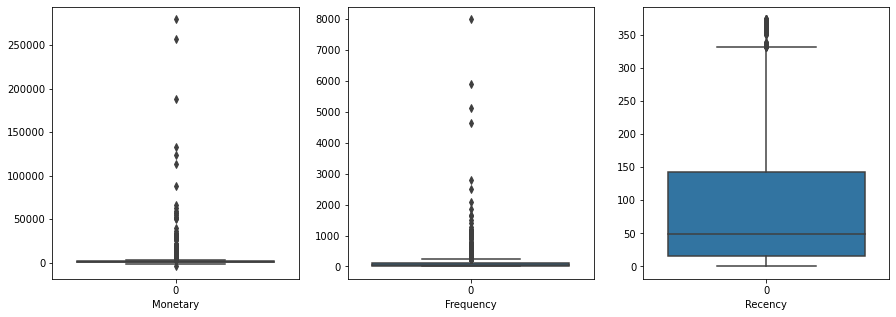

In [85]:
#checking outliers using boxplot

plt.figure(figsize=[15,5])

plt.subplot(1,3,1)
sns.boxplot(data=customer_RFM.Monetary)
plt.xlabel('Monetary')

plt.subplot(1,3,2)
sns.boxplot(data=customer_RFM.Frequency)
plt.xlabel('Frequency')

plt.subplot(1,3,3)
sns.boxplot(data=customer_RFM.Recency)
plt.xlabel('Recency')

plt.show()

- It looks like we have outliers on all columns. Now treating these completely depends upon the choice. 
- If you are looking through the statistical side, anything above 95 or 99 percentile is an outlier and can be treated.
- Also, if more preference is given for business objectives, many of these data points which are outliers cannot be removed. 

#### We will remove all those below 5 percentile and above 95 percentile

In [86]:
#for column 'Monetary'

percentile_5 = customer_RFM.Monetary.quantile(0.05)
percentile_95 = customer_RFM.Monetary.quantile(0.95)
IQR = percentile_95 - percentile_5
customer_RFM = customer_RFM[(customer_RFM.Monetary >= percentile_5 - 1.5*IQR) & (customer_RFM.Monetary <= percentile_95 + 1.5*IQR)]

#for Frequency

percentile_5 = customer_RFM.Frequency.quantile(0.05)
percentile_95 = customer_RFM.Frequency.quantile(0.95)
IQR = percentile_95 - percentile_5
customer_RFM = customer_RFM[(customer_RFM.Frequency >= percentile_5 - 1.5*IQR) & (customer_RFM.Frequency <= percentile_95 + 1.5*IQR)]

#for Recency

percentile_5 = customer_RFM.Recency.quantile(0.05)
percentile_95 = customer_RFM.Recency.quantile(0.95)
IQR = percentile_95 - percentile_5
customer_RFM = customer_RFM[(customer_RFM.Recency >= percentile_5 - 1.5*IQR) & (customer_RFM.Recency <= percentile_95 + 1.5*IQR)]


#### Let us keep a copy of dataframe before scaling for end analysis.

In [87]:
temp_customer_RFM = customer_RFM.copy()
temp_customer_RFM.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


## Rescaling

In [88]:
#scaling using StandardScaler

scaler = StandardScaler()

customer_RFM[['Monetary','Frequency','Recency']] = scaler.fit_transform(customer_RFM[['Monetary','Frequency','Recency']])

customer_RFM.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,-0.723738,-0.752888,2.301611
1,12347.0,1.731617,1.042467,-0.906466
2,12348.0,0.300128,-0.463636,-0.183658
3,12349.0,0.277517,-0.044720,-0.738141
4,12350.0,-0.533235,-0.603275,2.143188


#### We do not need CustomerID for modelling and can be dropped.

In [89]:
new_customer_RFM = customer_RFM.drop('CustomerID',axis=1)

- **Before feeding the data for clustering, we should check whether the data has some cluster tendency existing within it.**
- **If the data points are completely randomly spaced, then we would still get clusters but will be of no use.**
- **Hence we use a metric called Hopkins test to validate the same.**

## Cluster Tendency using Hopkins

In [90]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [91]:
#checking Hopkins value

hopkins(new_customer_RFM)

0.9583558729802168

- **Any value above 0.8 is good and the dataset can be taken forward for modelling.**

## Modelling

#### We will first perform K-means with a random number of clusters and then will dive into optimized values of K(no of clusters).

In [92]:
#performing with number of clusters = 4

kmeans = KMeans(n_clusters=4 , max_iter=50)

kmeans.fit(new_customer_RFM)

KMeans(max_iter=50, n_clusters=4)

In [93]:
kmeans.labels_

array([2, 3, 0, ..., 2, 0, 0])

## Optimized methods for obtaining number of clusters

### Elbow Curve

- **SSD(Sum of Square of distances)**
- **Inertia will calculate the sum of square of distances of each data point from it's nearest cluster center.**
- **As the number of clusters increases, the Inertia decreases, because the points become closer to clusters.**

- **We need to find an optimum value of cluster after which adding more clusters do not create a significant change in Inertia.**

In [94]:
#we will create a list of some cluster numbers and append the SSD of each cluster to a list 'SSD'

range_of_clusters = [2,3,4,5,6,7,8]
ssd = []
for cluster in range_of_clusters : 
    kmeans = KMeans(n_clusters=cluster, max_iter=50)
    kmeans.fit(new_customer_RFM)
    
    ssd.append(kmeans.inertia_)
    
ssd

[7661.763652146139,
 4433.5868058115375,
 3360.7590214742713,
 2802.833031700485,
 2392.155834081171,
 2038.56437677336,
 1825.7833590403138]

#### Lets visualize SSD

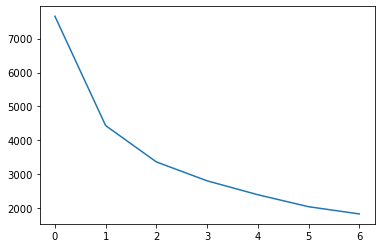

In [95]:
plt.plot(ssd)
plt.show()

#### The labels on x-axis are index values of cluster list - > [2 ,3, 4, 5, 6, 7, 8]

- **Here we can see that when changing from 2 clusters to 3 clusters, there is a significant drop in SSD.**
- **From 3 clusters to 4 clusters, the change is not that significant.**

### Silhouette Analysis

- **Here, we talk about Cohesion and Separation.**

- **When comparing clusters, we ideally want the data points of each cluster to be situated at far away from the data points of neighnouring clusters.This is called Separation.**
- **Similarly within a cluster, the data points must be closely bound (Cohesion).**

- **Silhouette score gives an idea about how data points behave and helps in determining the best possible value for clusters.**
- **Silhouette score = (b - a) / max(b,a) ,** 
#### where b is the average distance of a data point to all the data points of neighnouring cluster and a is the avaerage distance of data points to each other within a cluster.**

Silhouette Score ranges from -1 to 1.
A value close to 1 tells that the data points are similar to each other within a cluster and -1 tells that they are dissimilar withing a cluster.

In [96]:
range_of_clusters = [2,3,4,5,6,7,8]

for cluster in range_of_clusters : 
    kmeans = KMeans(n_clusters=cluster,max_iter=50)
    kmeans.fit(new_customer_RFM)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(new_customer_RFM,cluster_labels)
    
    print('For {} clusters, the silhouette score is {}'.format(cluster,silhouette_avg ))

For 2 clusters, the silhouette score is 0.541842117113117
For 3 clusters, the silhouette score is 0.5084896296141937
For 4 clusters, the silhouette score is 0.4779103379918315
For 5 clusters, the silhouette score is 0.4643022374630045
For 6 clusters, the silhouette score is 0.4171445889132789
For 7 clusters, the silhouette score is 0.41763065866927357
For 8 clusters, the silhouette score is 0.4073300974185019


- **From Elbow curve, we saw that 3 clusters are ideal to go with. Here, after Silhouette analysis, we can see the values are almost negligible for 2 & 3 clusters.**

- **Always compare both methods to arrive at a practical number of clusters taking into consideration business requirements.**

### Here we will proceed with 3 clusters.

In [97]:
#running K-means again with 3 clusters

kmeans = KMeans(n_clusters=3 , max_iter=50)

kmeans.fit(new_customer_RFM)

KMeans(max_iter=50, n_clusters=3)

In [98]:
kmeans.labels_

array([1, 0, 2, ..., 1, 2, 2])

#### We can now merge the labels to the dataframe and compare with CustomerID's.

In [99]:
temp_customer_RFM.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [100]:
temp_customer_RFM['Cluster ID'] = kmeans.labels_
temp_customer_RFM.head()

,CustomerID,Monetary,Frequency,Recency,Cluster ID
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,1


#### Let us now check each of the Metrics against the cluster id's

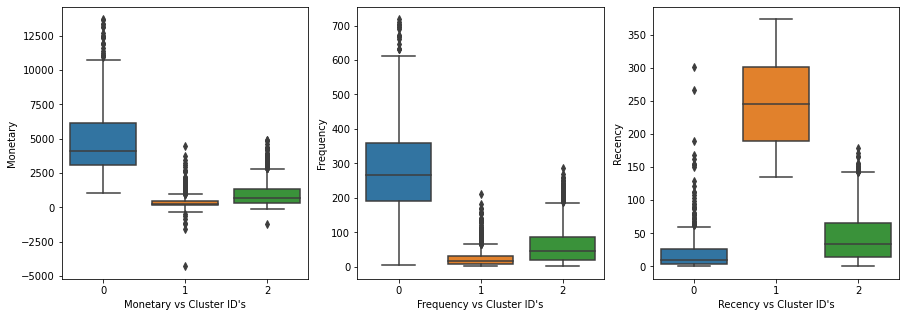

In [101]:


plt.figure(figsize=[15,5])

plt.subplot(1,3,1)
sns.boxplot(x='Cluster ID', y='Monetary', data=temp_customer_RFM)
plt.xlabel("Monetary vs Cluster ID's")

plt.subplot(1,3,2)
sns.boxplot(x='Cluster ID', y='Frequency', data=temp_customer_RFM)
plt.xlabel("Frequency vs Cluster ID's")

plt.subplot(1,3,3)
sns.boxplot(x='Cluster ID', y='Recency', data=temp_customer_RFM)
plt.xlabel("Recency vs Cluster ID's")

plt.show()

- **Customers in Cluster 0 seems to have ordered the most number of items and spent maximum amount while Cluster 2 being moderately perfroming these. Cluster 1 appears to be the group who are least active.**

- **Cluster 1 customers have shown Recency values of almost 250/year. So, company can take a call on how to bring back them to businees.**

- **Among all the metrics, Cluster 0 customers have performed well. They must be the group who are actively buying items.**

##### We have only performed analysis with 3 clusters, the same can be experimented with more clusters.

##                                                       Thank you!